# **<center>Notebook: Memory for Novelty Based Exploration</center>**


**Reference**
1. Savinov, N., Raichuk, A., Marinier, R., Vincent, D., Pollefeys, M., Lillicrap, T., & Gelly, S. (2018). Episodic curiosity through reachability. arXiv preprint arXiv:1810.02274.
2. Tang, H., Houthooft, R., Foote, D., Stooke, A., Xi Chen, O., Duan, Y., ... & Abbeel, P. (2017). # exploration: A study of count-based exploration for deep reinforcement learning. Advances in neural information processing systems, 30.
3. Raffin, A., Hill, A., Gleave, A., Kanervisto, A., Ernestus, M., & Dormann, N. (2021). Stable-baselines3: Reliable reinforcement learning implementations. Journal of Machine Learning Research, 22(268), 1-8.
4. Chevalier-Boisvert, M., Dai, B., Towers, M., Perez-Vicente, R., Willems, L., Lahlou, S., ... & Terry, J. (2024). Minigrid & miniworld: Modular & customizable reinforcement learning environments for goal-oriented tasks. Advances in Neural Information Processing Systems, 36.

In this notebook we present the implementation of method in the paper **"# exploration: A study of count-based exploration for deep reinforcement learning"**, which we refer to as count-based intrinsic reward, and in the paper **"Episodic curiosity through reachability"**, which we refer to as episodic-curiousity intrinsic reward.

## **1. Setting up the libraries** 

In [1]:
# Run these commands from the terminal to install related libraries and set up the working environment
# pip install gymnasium # Install the gymnasium library with RL environments
# pip install minigrid # Install the Minigrid library contains simple and easily configurable grid world environments for RL. 
# pip install stable-baselines3 # Install the Stable Baselines 3 library contains RL Algorithm

In [2]:
# Import the libraries and check if they are working
import random, copy
from collections import deque

import torch
import gymnasium as gym
import minigrid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from stable_baselines3 import PPO
from gymnasium.core import Wrapper
from minigrid.wrappers import ImgObsWrapper # Convert the observation space into an image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import get_policy_kwargs
from callbacks.Eval_Callback import Eval_Callback

# Set seed.
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **2. Introducing the Minigrid Environment**


- We will start with the introduction of the Minigrid environments (https://minigrid.farama.org/).
- There are many environments with low to high levels of difficulty available in the Minigrid package. 🎮 
- They also allow customization to suit your needs (such as maze size, adding objects, changing observation space). 😊
<p align="center">
  <img src="https://minigrid.farama.org/_images/BlockedUnlockPickupEnv.gif" width="300" height="150">
</p>


- In this tutorial, we will use the empty 16x16 environment, wherein the task of the agent is to reach the goal (the green square). 


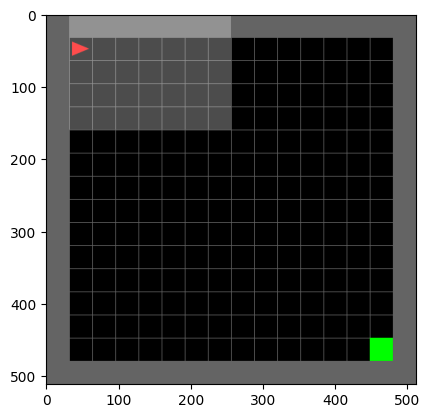

In [3]:
env = gym.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)

ob, _ = env.reset()
img = env.render()
plt.imshow(img);

### 2.1 Environment Information


- In Minigrid environments, there are typically 7 **actions** available.
- However, in this specific environment, we will only utilize the first 3 moving actions. 🚶‍♂️🚶‍♀️🚶

<span style=" font-weight:bold;">Action Space</span>
| Num   | Name | Action |
|--------|-----|--------|
| 0  | left  | Turn left |
| 1    | right  | Turn right  |
| 2| forward | Move forward |
| 3  | pickup  | Unused|
| 4    | drop  | Unused  |
| 5| toggle  | Unused|
| 6| done  | Unused   |





In [4]:
print(env.action_space) 

Discrete(7)


<span style="font-weight:bold;">Observation Space</span>

- Here we use the **observation space**, which is an image of shape (7,7,3).




In [5]:
print(env.observation_space)

Box(0, 255, (7, 7, 3), uint8)


<span style="font-weight:bold;">Reward</span>

- The agent will be given a **reward** of $1 - 0.9 * (step\_count / max\_steps)$ is given for success, and $0$ for failure.

## **3. Simple PPO**

- In this section, we will test a simple PPO algorithm on the above Minigrid environment. 🕹️
- Here, we use the implementation of PPO from Stable Baselines 3. 📊
- The result of this algorithm will be presented at the end of the notebook. 📝

### **3.1 Train PPO**

In [6]:
env = gym.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)

In [ ]:
simple_ppo_reward = {}

for run in range(5):
    eval_callback = Eval_Callback(eval_env=env, eval_freq=10000, n_eval_episodes=10)

    policy = PPO(policy="CnnPolicy", env=env, verbose=1, policy_kwargs=get_policy_kwargs(),  ent_coef=0.005)

    policy.learn(total_timesteps=100000, callback=eval_callback)

    simple_ppo_reward[f"run_{run}"] = eval_callback.record_reward

In [8]:
# policy.save("pretrained_models/simple_ppo")

### **3.2 Test PPO**

- You can uncomment this section to test our pre-trained model.

In [9]:
# policy = PPO.load("pretrained_models/simple_ppo")

In [10]:
# # Reset the environment to its initial state
# obs, _ = env.reset()
# count = 1
# reward_list = []
# # Perform some actions in the environment
# while count <= 50:
#     action, _ = policy.predict(obs) # Sample an action using the trained policy
    
#     # print(observation, action)

#     obs, reward, done, truncated, info = env.step(action)  # Take a step in the environment


#     # If the episode is finish either done or truncated, record reward & reset the environment
#     if done or truncated:
#         reward_list.append(reward)
#         observation = env.reset()
#         count += 1

# print(f"The average reward for 50 runs are: {np.mean(reward_list)}")
# env.close()  # Close the environment

## **4. Count-Based Observation Bonus**

- In this section, we will present our implementation of the count-based bonus intrinsic reward. 
- Here, we implement it as a wrapper to the Minigrid environment -> modifying the .step() function, so as to include the bonus reward. 🔄
- The result of this algorithm will be presented at the end of the notebook. 📊

### **4.1 Key Points**

- The idea behind count-based observation is to use a memory to record the number the number of time a state has been visited. Subsequently, higher rewards are given to states or states-actions that are less visited. 
- The intrinsic reward, in counting method based on states-actions, is denoted as $r^{+}(s,a)$ is calculated using the formula: $r^{+}(s,a)=\beta/\sqrt{(n(\phi(s,a)))}$ where $\beta$ is a hyperparameter and $\phi$ is a hashing function.
- A simple and efficient choice for $\phi$ is a SimHash function, converting high dimensional data into hash codes: $$\phi(s) = sgn(Ag(s)) \in \{-1,1\}^k$$ where $g$ is an optional processing function and $A$ is a matrix drawn from standard Gaussian distribution $N(0,1)$.
- An advanced method is to use Autoencoder to learn the lower dimension vector representation. This autoencoder has a sigmoid activation function $b(s)$ that constraint the representation vector to range $\{0,1\}$


<div style="text-align:center">
    <img src="./image/AutoEncoder_for_Count_Based_Exploration.png" alt="AutoEncoder forr Count Based Exploration" width="1000" height="300">
</div>


### **4.2 Model**

In [11]:
import math 

class SimHash(object) :
  def __init__(self, state_emb, k) :
    self.A = np.random.normal(0, 1, (k, state_emb))

  def hash(self, state) :
    hash_key = str(np.sign(self.A @ np.array(state)).tolist())                          # -> the matrix A
    return hash_key


class CountBasedBonusWrapepr(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.M = {}                                                                     # -> Memory counting M                                                                         
        self.hash = SimHash(147, 56) 
        self.beta = 0.001                                                               # -> hyperparameter beta                                                 
    
    def _update_count_dict_(self, hash):
        """Function to update the counting library M, if hash is in count then + 1 otherwise create a new entry of value 0."""
        pre_count = 0

        if hash in self.M:
            pre_count = self.M[hash]
        new_count = pre_count + 1
        self.M[hash] = new_count

    def get_count(self, hash):
        return self.M[hash]

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        obs_flatten = obs.flatten()

        hash =  self.hash.hash(obs_flatten)

        self._update_count_dict_(hash)

        new_count = self.get_count(hash)                                                   # Get the count value after update the library. 

        bonus = self.beta / math.sqrt(new_count)                                           # Calculate the intrinsic reward.

        reward += bonus

        return obs, reward, terminated, truncated, info

In [12]:
env = gym.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)

#### **4.2.1 Train PPO with Count Based Bonus**

In [ ]:
count_base_reward = {}

for run in range(5):
    train_env = CountBasedBonusWrapepr(env)
    
    test_env = env

    eval_callback = Eval_Callback(eval_env=env, eval_freq=10000, n_eval_episodes=10)

    policy = PPO(policy="CnnPolicy", env=train_env, verbose=1, policy_kwargs=get_policy_kwargs(),  ent_coef=0.005)

    policy.learn(total_timesteps=100000, callback=eval_callback)

    count_base_reward[f"run_{run}"] = eval_callback.record_reward

In [14]:
# policy.save("pretrained_models/ppo_observation_count_bonus")

#### **4.2.2 Test PPO Agent with Count Based Bonus**

In [15]:
# policy = PPO.load("pretrained_models/ppo_observation_count_bonus")

In [16]:
# # Reset the environment to its initial state
# obs, _ = test_env.reset()
# count = 1
# reward_list = []
# # Perform some actions in the environment
# while count <= 50:
#     action, _ = policy.predict(obs) # Sample an action using the trained policy
    

#     obs, reward, done, truncated, info = test_env.step(action)  # Take a step in the environment

#     # If the episode is finish either done or truncated, record reward & reset the environment
#     if done or truncated:
#         reward_list.append(reward)
#         observation = test_env.reset()
#         count += 1

# print(f"The average reward for 50 runs are: {np.mean(reward_list)}")
# test_env.close()  # Close the environment

## **5. Episodic Curiousity through Reachability**

- In this section, we will present our implementation of the reachability bonus. 🚀
- Here, we will also implement it as a wrapper to the Minigrid environment. 
- This implementation is a simplified version of the implementation in the original paper, wherein the author uses a pretrained ResNet model to learn the feature vector from image input. 📝

### **5.1 Key Points**

- The main idea behind this method is to give reward to observations depending on how far it is to the observations recorded in the agent's memory.
- A neural network is created, with the task, to determine whether one observation can be reached from another labelled as 0 for unreachable and 1 for reachable. The network can be summarized as $C(E(o_i),E(o_j))$, where $E(o_i)$ and $E(o_j)$ is the feature embeddinng of observations $o_i$ and $o_j$, and $C\rightarrow [0,1]$ is a function that determinned reachability.
- A memory $M$ is used to record the embedding $e$ of visited observations. When a new observation is met, we will calculate the reachability to this obsevation from every observations stored in $M$ denoted as $C(M,e)=F(c_1,...,c_{|M|})$, where $F$ is a hyperparameter method, for instance, $F=max$. 
- The bonus denoted as $\beta$ is calculated as $\alpha*(\beta-C(M,e))$ where $\alpha$ and $\beta$ are hyperparameters.

<div style="text-align:center">
    <img src="./image/Episodic_Reachability_Architecture.png" alt="Episodic Curiosity through Reachability" width="1000" height="450">
</div>

### **5.2 Model**

In [17]:
class R_Model(nn.Module):
    def __init__(self):
        super(R_Model, self).__init__()
        
        # Define the number of output features after convolutional layers
        feature_output = 64

        # Embedding network -> In original implementation, the author used pretrained ResNet.
        self.embedding = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # Adjusted to match the number of input channels
                out_channels=32,
                kernel_size=3,
                stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(feature_output, 512)
        )

        self.classification = nn.Sequential(
            nn.Linear(512 * 2, 256),  # Combine the embeddings of two observations
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(), 
            nn.Linear(256, 2),  
            nn.Softmax(dim=1)  
        )

    def get_embedding(self, ob):
        ob = torch.tensor(ob.reshape(1,3,7,7), dtype=torch.float32).to(device)
        ob_emb = self.embedding(ob)
        return ob_emb
    
    def get_label(self, ob_1, ob_2):
        ob_1_emb = self.get_embedding(ob_1)
        ob_2_emb = self.get_embedding(ob_2)
        combined_embedding = torch.cat((ob_1_emb, ob_2_emb), dim=1).to(device)
        prob = self.classification(combined_embedding)
        return prob
        
    def get_reward(self, ob, M):
        max_reward = 0
        for ob_2 in M:
            with torch.no_grad():
                prob = self.get_label(ob, ob_2)
            prob = prob.to("cpu")
            value = prob[0][1]
            if value > max_reward:
                max_reward = value
        return max_reward.item()

In [18]:
class EpisodicCuriousityBonusWrapepr(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.based_bonus = 0.001
        self.M = []                                  # Memory storing current observation in current episode -> used to determine reachability of future step
        self.eps = []
        self.max_length = 10

        self.step_retrained_model = 0                                    
        self.r_model = R_Model().to(device)
        self.optimizer = optim.Adam(self.r_model.parameters(), lr=1e-4)
        self.criterion = nn.BCELoss()
        self.model_trained = False
        self.beta = 1
        self.alpha = 0.001

        self.history = deque(maxlen=10)                # Replay buffer storing data for traininng model
        self.k = 5                                  
        self.gamma = 1.2                               # Gap value between label reachable and unreachable


    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.eps.append(obs[0])
        self.M.append(obs[0])
        return obs
        
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.eps.append(obs)
 
        if terminated or truncated: 
            self.history.append(self.eps.copy())
            self.eps = []
            self.M = []

        # Train r_model
        self.step_retrained_model += 1
        if self.step_retrained_model == 30000:
            if len(self.history) != 0:
                X, y = self.create_training_data()                                                      # -> labelling the training data
                self.train_r_model(X, y)
                self.model_trained = True
                self.step_retrained_model = 0
            else:
                self.step_retrained_model = 0               

        if len(self.M) >= 2 and self.model_trained:                                                 # -> If network R is trained then start getting the reward
            bonus = self.r_model.get_reward(obs, self.M)
            bonus = self.alpha*(self.beta-bonus)
            reward += bonus
        
        # Storing observation in current memory M to determine reachability
        if len(self.M) > self.max_length:
            if not any(np.array_equal(obs, array) for array in self.M):
                self.M.pop(random.randint(0, len(self.M) - 1))
                self.M.append(obs)
        else:
            if not any(np.array_equal(obs, array) for array in self.M):
                self.M.append(obs)

        return obs, reward, terminated, truncated, info
    
    def create_training_data(self):
        """Function to create the training dataset of neural network R"""
        X = []
        y = []
        for episode in self.history:
            for _ in range(30):
                episode_with_indices = list(enumerate(episode))
                index, _ = random.choice(episode_with_indices)

                # Get random positive (reachable) example -> reachable 1
                # Calculate the maximum allowable value for 'step' to stay within the range of indices
                max_step = min(self.k, len(episode) - 1 - index)
                if max_step == 1:
                    step = 1
                elif max_step == 0:
                    continue
                else:
                    step = random.randint(1, max_step)
                X.append([episode[index], episode[index+step]])
                y.append(1)

                # Get random negative (unreachable) example -> non-reachable 0
                # If last few index then skip
                if self.k*self.gamma > len(episode) - 1 - index:
                    continue
                else:
                    step = random.randint(self.k*self.gamma, len(episode) - 1 - index)
                    X.append([episode[index], episode[index+step]])
                    y.append(0)
        return X, y
 

    def train_r_model(self, X, y):
        for _ in range(5):
            indices = list(range(len(X)))

            # Shuffle the indices
            random.shuffle(indices)

            # Reorder both X and y using the shuffled indices
            X_shuffled = [X[i] for i in indices]
            y_shuffled = [y[i] for i in indices]
         
            prob_stack = []
            for i in range(len(X)):
                prob = self.r_model.get_label(X_shuffled[i][0], X_shuffled[i][1])
                prob_stack.append(prob)
            prob_stack = torch.cat(prob_stack, dim=0)
            loss = self.criterion(prob_stack[:,1], torch.tensor(y_shuffled).float().to(device))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [19]:
env = gym.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)

#### **5.2.1 Train PPO with Episodic Curiousity**

In [ ]:
episodic_curiousity = {}

for run in range(5):
    train_env = EpisodicCuriousityBonusWrapepr(env)
    
    test_env = env  

    eval_callback = Eval_Callback(eval_env=env, eval_freq=10000, n_eval_episodes=10)

    policy = PPO(policy="CnnPolicy", env=train_env, verbose=1, policy_kwargs=get_policy_kwargs(),  ent_coef=0.005)

    policy.learn(total_timesteps=100000, callback=eval_callback)

    episodic_curiousity[f"run_{run}"] = eval_callback.record_reward

In [21]:
policy.save("pretrained_models/ppo_observation_episodic_curiousity")

#### **5.2.2 Test PPO Agent with Episodic Curiousity Bonus**

In [22]:
# policy = PPO.load("pretrained_models/ppo_observation_episodic_curiousity")

In [23]:
# # Reset the environment to its initial state
# obs, _ = test_env.reset()
# count = 1
# reward_list = []
# # Perform some actions in the environment
# while count <= 50:
#     action, _ = policy.predict(obs) # Sample an action using the trained policy
    
#     # print(observation, action)

#     obs, reward, done, truncated, info = test_env.step(action)  # Take a step in the environment


#     # If the episode is finish either done or truncated, record reward & reset the environment
#     if done or truncated:
#         reward_list.append(reward)
#         observation = test_env.reset()
#         count += 1

# print(f"The average reward for 50 runs are: {np.mean(reward_list)}")
# test_env.close()  # Close the environment

## **6. Results Visualization**

### **6.1 Saving Data**

In [24]:
eval_freq = 10000
total_timesteps = 100000

row_idx = [i for i in range(0, total_timesteps, eval_freq)]

df_simple_PPO = pd.DataFrame.from_dict(simple_ppo_reward, orient='index').T

df_simple_PPO.index = row_idx

df_count_base = pd.DataFrame.from_dict(count_base_reward, orient='index').T

df_count_base.index = row_idx

df_episodic_curiousity = pd.DataFrame.from_dict(episodic_curiousity, orient='index').T

df_episodic_curiousity.index = row_idx


# Save DataFrames to CSV files
df_simple_PPO.to_csv('data/simple_ppo_rewards.csv')
df_count_base.to_csv('data/count_base_rewards.csv')
df_episodic_curiousity.to_csv('data/episodic_curiousity.csv')



### **6.2 Load Data & Visualizing**

In [25]:
df_simple_PPO = pd.read_csv('data/simple_ppo_rewards.csv')
df_count_base = pd.read_csv('data/count_base_rewards.csv')
df_episodic_curiousity = pd.read_csv('data/episodic_curiousity.csv')

In [26]:
dfs = [df_simple_PPO, df_count_base, df_episodic_curiousity]

for df in dfs:
    df["mean"] = df.iloc[:,1:].mean(axis=1)
    df["mean_smoothed"] = df["mean"].ewm(alpha=1-0.9).mean()


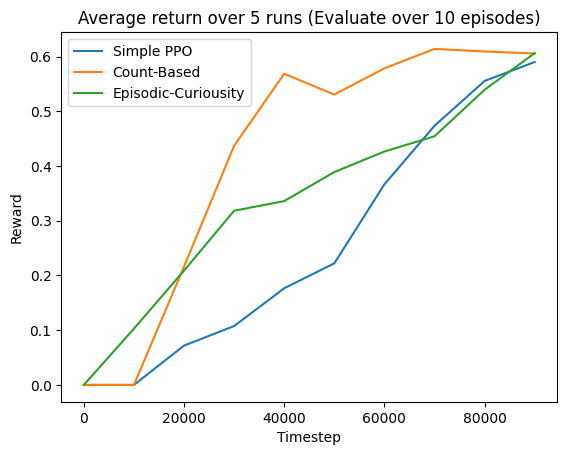

In [30]:
# Plot simple_ppo_reward
plt.plot(df_simple_PPO.iloc[:,0], df_simple_PPO['mean_smoothed'], label='Simple PPO')

# Plot count_base_reward
plt.plot(df_count_base.iloc[:,0], df_count_base['mean_smoothed'], label='Count-Based')

# Plot episodic_curiousity
plt.plot(df_episodic_curiousity.iloc[:,0], df_episodic_curiousity['mean_smoothed'], label='Episodic-Curiousity')

plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Average return over 5 runs (Evaluate over 10 episodes)')
plt.legend()
plt.show()
    

- The figure illustrates notable enhancements in the performance of simple PPO within the Minigrid environment facilitated by both count-based intrinsic reward exploration and episodic-curiosity intrinsic reward techniques. 
- Remarkably, the count-based exploration method emerges as the most effective, showcasing superior performance compared to episodic curiosity. 
- These enhancements underscore the efficacy of intrinsic reward mechanisms in augmenting the learning capabilities of PPO within the given environment.